# **Tackle Imbalanced Data Challenge**


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions: 


| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      | 
| _Predicting Customer Churn_ | ~5 : 1      | 
| _Tumor Type Estimation_ | ~2 : 1     | 
| _Predicting Job Change_ | ~10 : 1      | 


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:
- Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
- Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


* Identify typical patterns of imbalanced data challenges
* Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
* Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
* Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


----


First, let us import the required packages for this lab:


In [53]:
# !pip install imbalanced-learn

In [54]:
## Import packages here
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

## Some utility model training and evaluation methods 


Before we continue with more imbalanced classification scenarios, let's define some utility methods for you to simplify this lab and increase notebook readability. A method to define and train a logistic regression:


In [55]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs, 
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to define and train a random forest:


In [56]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to evaluate a classifier's predictions


In [57]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

In [58]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

A method to resample the original dataset


In [59]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

And a method to visualize metrics


In [60]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Scenario: Tumor Type Estimation


Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling.


This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

First, like other scenarios, let's load and split the dataset


In [61]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)
X_train, X_test, y_train, y_test = split_data(tumor_df)

and check its class distribution:


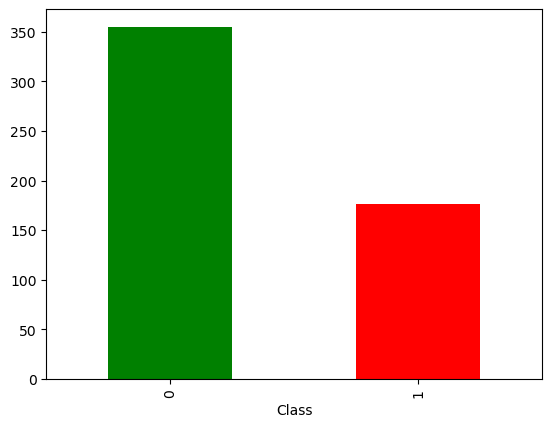

In [62]:
y_train.value_counts().plot.bar(color=['green', 'red']);

As we can see, this dataset is not as imbalanced as previous datasets. So that it is possible we dont need to use class reweighting and resampling in order to have good classification performance.


But we still create synthetic datasets with SMOTE and undersampling and class weights to compare their performance.


In [63]:
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [64]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)


Use tuned random forest parameters.


In [65]:
best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1: 0.8}, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

Train and evaluate different random forest models on the tumor type dataset.


In [66]:
# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))

In [67]:
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))

In [68]:
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))


       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


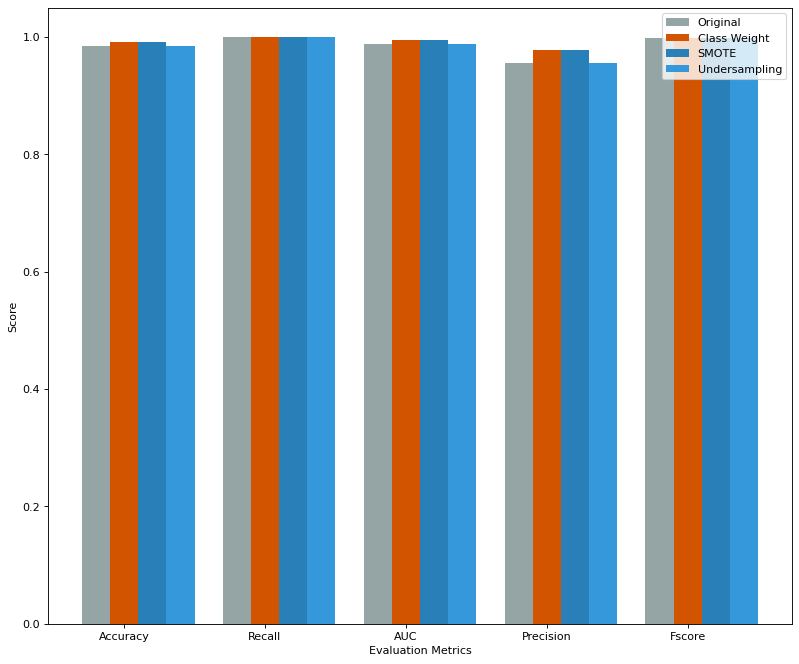

In [69]:
visualize_eval_metrics(results)


As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.


## Exercise: Predicting Job Change


Now it is time to apply what you have learned in this lab. We have an imbalanced HR dataset and we want to use it to build a classification model to predict if an employee is looking for a new job or not.


In [70]:
# Load the dataset
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col=False)

### Check its class distribution


<Axes: xlabel='Class'>

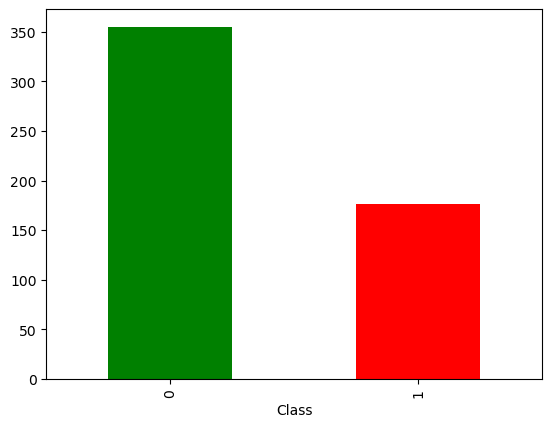

In [71]:
y_train.value_counts().plot.bar(color=['green', 'red'])


In [72]:
best_params = {'class_weight': {0: 0.1, 1: 0.9}}


In [73]:
results = []


### Split the dataset


In [74]:
X_train, X_test, y_train, y_test = split_data(hr_df)


### Build a logistic regression model with the original dataset


In [75]:
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)

### Add class weights to the model


In [76]:
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)

### Improve the model with SMOTE resampled dataset


In [78]:
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- city_development_index
- company_size
- company_type_Early Stage Startup
- company_type_Funded Startup
- company_type_NGO
- ...
Feature names seen at fit time, yet now missing:
- BareNuc
- BlandChrom
- Clump
- MargAdh
- Mit
- ...


### Improve the model with Undersampling resampled dataset


In [36]:
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")

<details><summary>Click here for a solution</summary>

```python
y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")
#metrics.plot_roc_curve(smote_model, X_test, y_test) 
results.append(result)
visualize_eval_metrics(results)
```

</details>


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


<!--## Change Log--!>


<!--|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-9-23|1.0|Yan|Created the initial version||2022-2-23|1.2|Steve Hord|QA pass|--!>


Copyright © 2021 IBM Corporation. All rights reserved.
